- Haz los push pop en el orden más adecuado y arregla los desastres.
Kizas primero pull bixetan, ta gero push en Melanie, pull hemen. BAdezpada kopixe ta pege kanpoan jupyterrak
- Ein mock example bat de cada cosa que he implementado hasta que no tenga errores.
Dana, inkluso lo de el dump y tal del saving class instances.
- Gero zuzendu beko gauza danak eta prepareu pipeline!

- Jarri bi aldiz (A) atala baten con non-noisy ta bestien con noisy data
- Ikusi zelan eitzen dan kalse bat kustoma gordetako memorian eta berriro atarateko, si depende de más clases.
- Ikusi hydran zelan zan gordetie clase bat hobeto
- Ikusi gordetako imagenak usando matplotlib por ejemplo zelan eitzen genun hydran
- Ikusi tripleten zelan zan exaktamente preprozesamentue!
- Behin Dim egokixe aukeratute emaitzak ikusi ostien, jarri hurrengo seksiñoa errepikatute asakotan edo loop bat agian eta bata bestien atzetik embedder danak trainie eta gordetie!
- Sólo los supervised embedding learners tiene sentido usarlos como métrica en lugar del L2 pa lo de la simulación...y quizás para lo del KNN tb. Lo ke pasa es que pra el FC ya tiene sentido usar un non-superivsed embedder.
- Pa entrenar la KNN para el Triplet, haz lo mismo hasta lo de preprocess fct y luego ya salta a su sección.
- Gero implemente noisy image pipeline


# (A) Determine Adequate Embedding Space Dimensionality
Using MDA (to see when the manifolds torsion starts), using KNN to see when locality of same class can be preserved well, also UMAP for this.

In [2]:
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
import os

from torch.utils.data import Dataset
from torchvision.io import read_image
from torch.utils.data import DataLoader

class ImageDataset(Dataset):
    def __init__(self, GT_file_path, images_dir_path):
        self.df_GTs = pd.DataFrame.from_dict(json.load(open(GT_file_path)))
        self.images_dir_path = images_dir_path
        self.len_data = len(self.df_GTs)

    def __len__(self):
        return self.len_data

    def __getitem__(self, idx):
        img_path = f"{self.images_dir_path}/IM_{self.df_GTs.iloc[idx,0]}_phiCR_{self.df_GTs.iloc[idx,1]}.png"
        image = read_image(img_path) #[1, 2X+1, 2X+1] torch tensor
        label = torch.Tensor([float(self.df_GTs.iloc[idx, 1])]).type(torch.float32) #[1] torch tensor of float32
        return image, label
    
# Train set Input!
GT_file_path_train = f"/home/oiangu/Desktop/Conical_Refraction_Polarimeter/OUTPUT/NOISY/TRAIN/GROUND_TRUTHS.json"
images_dir_path_train =f"/home/oiangu/Desktop/Conical_Refraction_Polarimeter/OUTPUT/NOISY/TRAIN/" 

num_images=3200
num_decimals = 2
random_seed = 666
n_jobs=8
exp_name="Noisy_Dataset"

emb_dims=[1,2,3,4,5,7,10,13,16,20]

save_stuff_path = f"/home/oiangu/Hippocampus/Conical_Refraction_Polarimeter/Embedders/Finding_Dimensionality_of_Manifold"
os.makedirs( save_stuff_path, exist_ok=True )

In [ ]:
training_data = ImageDataset(GT_file_path_train, images_dir_path_train)

In [ ]:
np.random.seed(random_seed)
random_indices = np.random.choice(range(len(training_data)), num_images, replace=False)
#random_indices = np.random.choice(range(2850), num_images, replace=False)
X21 = training_data[0][0].shape[1]
X = np.zeros( (num_images, X21**2), dtype=np.float32)
y = np.zeros((num_images), dtype=np.float64)

for j,idx in enumerate(random_indices):
    im, lab = training_data[idx]
    X[j, :] = im[0].flatten()
    y[j] = lab   

y_categoric = (np.around(y+np.pi, num_decimals)*10**num_decimals).astype(int)

In [ ]:
metrics={}

### MDS # y not used

In [ ]:
# MDS
args = {'metric':True, 'n_init':4, 'max_iter':50, 'dissimilarity':'euclidean'}
metrics['MDS']=[]

for dim in emb_dims:
    embedder = sk.manifold.MDS(n_components=dim, metric=args['metric'], n_init=args['n_init'],
                    max_iter=args['max_iter'], n_jobs=n_jobs, random_state=random_seed, dissimilarity=args['dissimilarity'])
    
    embedder.fit(X, y)
    metrics['MDS'].append(embedder.stress_)

fig, ax = plt.subplots(1,1,figsize=(10,10))
ax.plot(emb_dims, metrics['MDS'])
ax.set_ylim((0, max(metrics['MDS'])))
ax.set_title("MDS Stress by Embedding Space Dimension\n"+exp_name)
ax.grid(True)
plt.savefig(f"{save_stuff_path}/MDS_stress_{exp_name}.png")
plt.show()

### LLE # y not used

In [ ]:
# LLE
args = {'exp':'LLE_standard',"method":"standard", "n_neighbors": 100,"emb_dims": emb_dims, 'max_iter':50}
# Methods: standard, hessian, ltsa, modified (modified_tol) 
methods = ["standard", "ltsa", "hessian"]

for method in methods:
    args['method']=method
    metrics["LLE_"+method]=[]
    for dim in emb_dims:
        embedder = sk.manifold.LocallyLinearEmbedding(method=args['method'], n_neighbors=args['n_neighbors'],
              n_components=args['emb_dims'], max_iter=args['max_iter'], random_state=random_seed, n_jobs=n_jobs) 
        embedder = embedder.fit(X)
        metrics["LLE_"+method].append(embedder.reconstruction_error)
    
    fig, ax = plt.subplots(1,1,figsize=(10,10))
    ax.plot(emb_dims, metrics["LLE_"+method])
    ax.set_ylim((0, max(metrics["LLE_"+method])))
    ax.set_title(f"LLE {method} Reconstruction Error\n by Embedding Space Dimension\n"+exp_name)
    ax.grid(True)
    plt.savefig(f"{save_stuff_path}/LLE_{method}.png")
    plt.show()
    
fig, ax = plt.subplots(1,1,figsize=(10,10))
for method in methods:
    ax.plot(emb_dims, metrics["LLE_"+method], label=method)
    
ax.legend()
ax.set_title(f"LLE Reconstruction Error\n by Embedding Space Dimension\n"+exp_name)
ax.grid(True)
plt.savefig(f"{save_stuff_path}/LLE_{exp_name}.png")
plt.show()


### UMAP # y used in continous version

In [ ]:
args_sk_KNN = {'n_eighbors':50, 'weights':'uniform', 'algorithm':'auto', 'leaf_size':30, 'p':2,
               'metric':'minkowski', 'n_jobs':n_jobs}

# UMAP
args = {'exp':'UMAP', 'emb_dims':emb_dims, 'min_dist':0.1, 'n_neighbors':100, 'metric':'hamming', 'n_epochs':None,
       'target_metric':'l2'}
# Metrics: euclidean, canberra, cosine, manhattan, braycurtis, mahalanobis, hamming
metrics["UMAP"]=[]
for dim in emb_dims:
    embedder = umap.UMAP(n_components=args['emb_dims'], min_dist=args['min_dist'], n_epochs=args['n_epochs'],
            n_neighbors=args['n_neighbours'], metric=args['metric'], random_state=random_seed, n_jobs=n_jobs,
            target_metric=args['target_metric']) 
    embedder = embedder.fit(X,y)
    
    KNN = sk.neighbors.KNeighborsRegressor(n_neighbors=args_sk_KNN['n_neighbors'],
            weights=args_sk_KNN['weights'], algorithm=args_sk_KNN['auto'],
            leaf_size=args_sk_KNN['leaf_size'], p=args_sk_KNN['p'], 
            metric=args_sk_KNN['metric'], n_jobs=args_sk_KNN['n_jobs'])
    metrics["UMAP"].append(KNN.score(embedder.embedding_,y))
    
fig, ax = plt.subplots(1,1,figsize=(10,10))
ax.plot(emb_dims, metrics['UMAP'])
ax.set_ylim((0, max(metrics['MUAP'])))
ax.set_title("UMAP Embedding KNN Regression Score\n"+exp_name)
ax.grid(True)
plt.savefig(f"{save_stuff_path}/UMAP_score_knn_{exp_name}.png")
plt.show()

### NCA # y used in categorical version

In [ ]:
args_sk_KNN = {'n_eighbors':50, 'weights':'uniform', 'algorithm':'auto', 'leaf_size':30, 'p':2,
               'metric':'minkowski', 'n_jobs':n_jobs}

# NCA
args = {'exp':'NCA', 'emb_dims':emb_dims, 'init':'auto', 'max_iter':50, }
# init ‘auto’, ‘pca’, ‘lda’, ‘identity’, ‘random’
metrics["NCA"]=[]
for dim in emb_dims:
    embedder = sk.neighbors.NeighborhoodComponentsAnalysis(n_components=args['emb_dims'], init=args['init'],
                                max_iter=args['max_iter'], random_state=random_seed)
    X = embedder.fit_transform(X,y_categoric)
    KNN = sk.neighbors.KNeighborsRegressor(n_neighbors=args_sk_KNN['n_neighbors'],
            weights=args_sk_KNN['weights'], algorithm=args_sk_KNN['auto'],
            leaf_size=args_sk_KNN['leaf_size'], p=args_sk_KNN['p'], 
            metric=args_sk_KNN['metric'], n_jobs=args_sk_KNN['n_jobs'])
    metrics["NCA"].append(KNN.score(X,y_categoric))
      
fig, ax = plt.subplots(1,1,figsize=(10,10))
ax.plot(emb_dims, metrics['NCA'])
ax.set_ylim((0, max(metrics['NCA'])))
ax.set_title("NCA Embedding KNN Regression Score\n"+exp_name)
ax.grid(True)
plt.savefig(f"{save_stuff_path}/NCA_score_knn_{exp_name}.png")
plt.show()  

### Save gathered metrics

In [ ]:
import json
# the json file where the output must be stored
out_metrics = open(f"{save_stuff_path}/Metrics_{exp_name}.json", "w")
  
json.dump({'Emb_dims':emb_dims, 'Metrics':metrics}, out_metrics)
  
out_metrics.close()

In [8]:
# pa ver la variedad nooisy y non-noisy, porke los noisy pueden hacer de puente de einstein rosen sino entre partes del manifold
# pa hacer embedding spaces para knn o fc o pa usarlo de simulated metric en plan euclidean ya no lo sé...
# supongo que si es un embedding ke mira los GT entonces noisy, si no...sólo se fija en la topología digamos...mejor non-noisy pa evitar puentes?

# (B) Class to Use Embedding Spaces for KNN

In [ ]:
args_sk_KNN = {'n_eighbors':50, 'weights':'distance', 'algorithm':'auto', 'leaf_size':30, 'p':2,
               'metric':'minkowski', 'n_jobs':n_jobs}

def KNN_Regressor():
    def __init__(self, embedder_func, args_sk_KNN):
        # ‘auto’, ‘ball_tree’, ‘kd_tree’, ‘brute’
        # ‘uniform’, ‘distance’
        self.embedder_func = embedder_func
        self.K = K
        self.KNN = sk.neighbors.KNeighborsRegressor(n_neighbors=args_sk_KNN['n_neighbors'],
                    weights=args_sk_KNN['weights'], algorithm=args_sk_KNN['auto'],
                    leaf_size=args_sk_KNN['leaf_size'], p=args_sk_KNN['p'], 
                    metric=args_sk_KNN['metric'], n_jobs=args_sk_KNN['n_jobs'])
        self.fitted = False
    
    def fit(self, X, y, already_embedded_X=False): # X [N_samples, dim_feats], y [N_samples] # y can be to regression floats!
        if not already_embedded_X:
            X = self.embedder_func(X) # [N_samples, dim_feats]
        self.KNN = self.KNN.fit(X, y)
        self.fitted = True
    
    def score(self, X, y, already_embedded_X=False):
        if not already_embedded_X:
            X = self.embedder_func(X)
        return self.KNN.score(X,y)
        
    def predict(self, X, already_embedded_X=False):
        if not already_embedded_X:
            X = self.embedder_func(X)
        return self.KNN.predict(X)
    
class Sklearn_embedder():
    def __init__(self, embedder, preprocess_fct):
        self.preprocess_fct = preprocess_fct
        self.embedder = embedder
    
    def __call__(self, X):
        return self.embedder.transform( self.preprocess_fct(X) )

# (C) Generate Embedding Space Transformers
## Input Image Dataset to train the embedders and choose Embedder Instance

In [ ]:
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
import pickle

In [ ]:
from torch.utils.data import Dataset
from torchvision.io import read_image
from torch.utils.data import DataLoader

class ImageDataset(Dataset):
    def __init__(self, GT_file_path, images_dir_path):
        self.df_GTs = pd.DataFrame.from_dict(json.load(open(GT_file_path)))
        self.images_dir_path = images_dir_path
        self.len_data = len(self.df_GTs)

    def __len__(self):
        return self.len_data

    def __getitem__(self, idx):
        img_path = f"{self.images_dir_path}/IM_{self.df_GTs.iloc[idx,0]}_phiCR_{self.df_GTs.iloc[idx,1]}.png"
        image = read_image(img_path) #[1, 2X+1, 2X+1] torch tensor
        label = torch.Tensor([float(self.df_GTs.iloc[idx, 1])]).type(torch.float32) #[1] torch tensor of float32
        return image, label

Choose Dataset and **training** hyperparameters for the Embedding Generation

In [ ]:
GT_file_path_train = f"/home/oiangu/Desktop/Conical_Refraction_Polarimeter/OUTPUT/NOISY/TRAIN/GROUND_TRUTHS.json"
images_dir_path_train =f"/home/oiangu/Desktop/Conical_Refraction_Polarimeter/OUTPUT/NOISY/TRAIN/" 

num_images=3200
num_decimals = 3
random_seed = 666
n_jobs=8

emb_dims=10

save_stuff_path = f"/home/oiangu/Hippocampus/Conical_Refraction_Polarimeter/OUTPUT/LIBRARIES_OF_THEORETICAL_D/Basler_like_R0_300x_w0_300x_Z_50x_64bit/SIMULATIONS/UMAP_Regressor/"

In [ ]:
training_data = ImageDataset(GT_file_path_train, images_dir_path_train)

Choose Embedder to use and its hyperparameters

In [ ]:
# PCA -> Existe la incremental PCA por si es massa grande el dataset!
args = {'exp':'PCA','emb_dims':emb_dims, "whiten":True}
embedder = sk.decomposition.PCA(n_components=args['emb_dims'], whiten=args['whiten'], random_state=random_seed)

# KPCA
args = {'exp':'KPCA_rbf', 'emb_dims':emb_dims, 'kernel':'rbf', 'fit_inverse':True, }
# kernels: linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘cosine’, ‘precomputed’
embedder = sk.decomposition.KernelPCA(n_components=args['emb_dims'], kernel=args['kernel'], 
                fit_inverse_transform=args['fit_inverse'], max_iter=args['max_iter'], 
                        random_state=random_seed, n_jobs=n_jobs)

# LLE 
args = {'exp':'LLE_standard',"method":"standard", "n_neighbors": 500,"emb_dims": emb_dims, 'max_iter':50}
# Methods: standard, hessian, ltsa, modified (modified_tol) 
embedder = sk.manifold.LocallyLinearEmbedding(method=args['method'], n_neighbors=args['n_neighbors'],
              n_components=args['emb_dims'], max_iter=args['max_iter'], random_state=random_seed, n_jobs=n_jobs)

# UMAP -> uses y continous
args = {'exp':'UMAP', 'emb_dims':emb_dims, 'min_dist':0.1, 'n_neighbors':500, 'metric':'hamming', 'n_epochs':None,
       'target_metric':'l2'}
# Metrics: euclidean, canberra, cosine, manhattan, braycurtis, mahalanobis, hamming
embedder = umap.UMAP(n_components=args['emb_dims'], min_dist=args['min_dist'], n_epochs=args['n_epochs'],
            n_neighbors=args['n_neighbours'], metric=args['metric'], random_state=random_seed, n_jobs=n_jobs,
                    target_metric=args['target_metric']) 

# ISOMAP
args = {'exp':'ISOMAP', 'n_neighbors':10, 'emb_dims':emb_dims, 'max_iter':50, 'neighbors_algorithm':'auto', 'metric':'minkowski' }
embedder = sk.manifold.Isomap( n_neighbors=args['n_neighbors'],n_components=args['emb_dims'],
                    max_iter=args['max_iter'], neighbors_algorithm=args['auto'], n_jobs=n_jobs,
                    metric=args['metric'], p=2, random_state=random_seed)

# NCA -> uses y categorical
args = {'exp':'NCA', 'emb_dims':emb_dims, 'init':'auto', 'max_iter':50 }
# init ‘auto’, ‘pca’, ‘lda’, ‘identity’, ‘random’
embedder = sk.neighbors.NeighborhoodComponentsAnalysis(n_components=args['emb_dims'], init=args['init'],
                                max_iter=args['max_iter'], random_state=random_seed)

# Triplet
args = {'exp':'TRIPLET_CNN', 'emb_dims':10}

Plot example inputted images

In [ ]:
fig, ax_array = plt.subplots(7, 7)
axes = ax_array.flatten()
for i, ax in enumerate(axes):
    im, lab = training_data[i]
    ax.imshow(im[0])
plt.setp(axes, xticks=[], yticks=[], frame_on=False)
plt.tight_layout(h_pad=0.4, w_pad=0.0001)

Generate proper finite dataset for Embedders! X,y

In [ ]:
np.random.seed(random_seed)
random_indices = np.random.choice(range(len(training_data)), num_images, replace=False)
#random_indices = np.random.choice(range(2850), num_images, replace=False)
X21 = training_data[0][0].shape[1]
X = np.zeros( (num_images, X21**2), dtype=np.float32)
y = np.zeros((num_images), dtype=np.float64)

for j,idx in enumerate(random_indices):
    im, lab = training_data[idx]
    X[j, :] = im[0].flatten()
    y[j] = lab   

y_categoric = (np.around(y+np.pi, num_decimals)*10**num_decimals).astype(int)

# for plotting purposes
df = pd.DataFrame({'y':y})
df['phiCR'] = df["y"].astype(str)

### Apply pre-embedding pre-process function to the dataset

In [ ]:
pre_process_name = "normalize_to_max_and_iX"

import torch

def compute_intensity_gravity_centers_torch( images):
    """
        Expects input image to be an array of dimensions [N_imgs, h, w].
        It will return an array of gravity centers [N_imgs, 2(h,w)] in pixel coordinates
        Remember that pixel coordinates are set equal to array indices

    """
    # image wise total intensity and marginalized inensities for weighted sum
    intensity_in_w = torch.sum(images, dim=1) # weights for x [N_images, raw_width]
    intensity_in_h = torch.sum(images, dim=2) # weights for y [N_images, raw_height]
    total_intensity = intensity_in_h.sum(dim=1) # [N_images]

    # Compute mass center for intensity
    # [N_images, 2] (h_center,w_center)
    return torch.nan_to_num( torch.stack(
        (torch.matmul(intensity_in_h.float(), torch.arange(images.shape[1], 
                                    dtype=torch.float32, device=device))/total_intensity,
         torch.matmul(intensity_in_w.float(), torch.arange(images.shape[2], 
                                    dtype=torch.float32, device=device))/total_intensity),
        dim=1
        ), nan=0.0, posinf=None, neginf=None)


def compute_raws_to_centered_iXs_torch( images, X, device):

    g_raw = compute_intensity_gravity_centers_torch(images) # [ N_images, 2]

    # crop the iamges with size (X+1+X)^2 leaving the gravity center in
    # the central pixel of the image. In case the image is not big enough for the cropping,
    # a 0 padding will be made.
    centered_images = torch.zeros( ( images.shape[0], 2*X+1, 2*X+1),  dtype = images.dtype, 
                                  device=device)

    # we round the gravity centers to the nearest pixel indices
    g_index_raw = torch.round(g_raw).int() #[ N_images, 2]

    # obtain the slicing indices around the center of gravity
    # TODO -> make all this with a single array operation by stacking the lower and upper in
    # a new axis!!
    # [ N_images, 2 (h,w)]
    unclipped_lower = g_index_raw-X
    unclipped_upper = g_index_raw+X+1

    # unclipped could get out of bounds for the indices, so we clip them
    lower_bound = torch.clip( unclipped_lower.float(), min=torch.Tensor([[0,0]]).to(device),
                             max=torch.Tensor(list(images.shape[1:])).unsqueeze(0).to(device)).int()
    upper_bound = torch.clip( unclipped_upper.float(), min=torch.Tensor([[0,0]]).to(device),
                             max=torch.Tensor(list(images.shape[1:])).unsqueeze(0).to(device)).int()
    # we use the difference between the clipped and unclipped to get the necessary padding
    # such that the center of gravity is left still in the center of the image
    padding_lower = lower_bound-unclipped_lower
    padding_upper = upper_bound-unclipped_upper

    # crop the image
    for im in range(g_raw.shape[0]):
        centered_images[im, padding_lower[ im, 0]:padding_upper[ im, 0] or None,
                                    padding_lower[ im, 1]:padding_upper[ im, 1] or None] = \
                  images[im, lower_bound[ im, 0]:upper_bound[ im, 0],
                                      lower_bound[ im, 1]:upper_bound[ im, 1]]

    return centered_images

def normalize_to_max_and_iX(images, dtype=np.float64,
                    iX_dev='cpu', out_dev='cpu', X=302): # images expected to be [N_images, h, w]
    images= images.astype(dtype)/np.expand_dims( np.amax(images, axis=(-2,-1) ), (-2,-1) )
    return compute_raws_to_centered_iXs_torch( torch.from_numpy(images).to(device), X, device).to('cpu').numpy()

preprocess_fct = normalize_to_max_and_iX

In [ ]:
X = preprocess_fct(X) # apply preprocess funct

## Run Embedding Training and KNN Training after it
Note that the embedders alone can be also used as metric for the simulation coordinate descent or Nedler Mead.

And note also that the embedder is still required for inference in KNN.

In [ ]:
date = datetime.now().strftime("%d/%m/%Y %H:%M:%S")
f_name_emb = f'{args['exp_name']}_EMBEDDER_n_images_{num_images}_emb_dims_{emb_dims}_pre_process_{pre_process_name}_n_decimals_{num_decimals}_seed_{random_seed}_date_{date}.sav'
f_name_knn = f'{args['exp_name']}_KNN_n_images_{num_images}_emb_dims_{emb_dims}_pre_process_{pre_process_name}_n_decimals_{num_decimals}_seed_{random_seed}_date_{date}.sav'

Train Embedder

In [ ]:
if args['exp_name']=='NCA': # then y categorical
    X_embedded = embedder.fit_transform(X, y=y_categoric)
else: # in relaity only UMAP uses y from the rest, but it can handle y continous
    X_embedded = embedder.fit_transform(X, y=y)

Train KNN

In [ ]:
knn_regressor = KNN_Regressor( Sklearn_embedder( embedder, preprocess_fct), args_sk_KNN)
knn_regressor.fit(X_embedded, y, already_embedded_X=True)

Save trained embedder and knn

In [ ]:
with open(save_stuff_path+f_name_emb, 'wb') as f:
    pickle.dump(embedder, f)
with open(save_stuff_path+f_name_knn, 'wb'):
    pickle.dump(knn_regressor, f)

Load Trained Embedder

In [ ]:
# embedder = pickle.load((open(save_stuff_path+f_name, 'rb')))

Visualize resulting embedding in lower dimensions using PCA, first 2d PCA

In [ ]:
#X_embedded = embedder.transform(x)

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=2)

principalComponents = pca.fit_transform(X_embedded)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])
df['principal component 1'] = principalDf['principal component 1']
df['principal component 2'] = principalDf['principal component 2']

Using Bokeh see 2d PCA

In [ ]:
from io import BytesIO
from PIL import Image
import base64
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, ColumnDataSource, LinearColorMapper
from bokeh.palettes import Spectral10
import plotly.express as px

output_notebook()

def embeddable_image(data):
    img_data = data.values.reshape(X21,X21).astype(np.uint8)
    image = Image.fromarray(img_data, mode='L').resize((64, 64), Image.BICUBIC)
    buffer = BytesIO()
    image.save(buffer, format='png')
    for_encoding = buffer.getvalue()
    return 'data:image/png;base64,' + base64.b64encode(for_encoding).decode()

df['image'] = pd.DataFrame(data=X, columns=list(range(X.shape[1]))).apply(embeddable_image, axis=1)

datasource = ColumnDataSource(df)
color_mapping = LinearColorMapper(
    palette='Magma256',
    low=y.min(),
    high=y.max()
)

plot_figure = figure(
    title='PCA projection of the CR dataset',
    plot_width=800,
    plot_height=800,
    tools=('pan, wheel_zoom, reset')
)

plot_figure.add_tools(HoverTool(tooltips="""
<div>
    <div>
        <img src='@image' style='float: left; margin: 5px 5px 5px 5px'/>
    </div>
    <div>
        <span style='font-size: 16px; color: #224499'>phiCR:</span>
        <span style='font-size: 18px'>@phiCR</span>
    </div>
</div>
"""))

plot_figure.circle(
    'principal component 1',
    'principal component 2',
    source=datasource,
    color=dict(field='phiCR', transform=color_mapping),
    line_alpha=0.6,
    fill_alpha=0.6,
    size=7
)
show(plot_figure)

Now 3d PCA

In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)

principalComponents = pca.fit_transform(X_embedded)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2', 'principal component 3'])
df['principal component 1'] = principalDf['principal component 1']
df['principal component 2'] = principalDf['principal component 2']
df['principal component 3'] = principalDf['principal component 3']

Using plotly

In [ ]:
fig=px.scatter_3d(df, x="principal component 1", y="principal component 2", z="principal component 3", color="y")
fig.update_traces(marker={"size":3})
fig.update_yaxes(scaleanchor="x", scaleratio=1)

fig.write_image(f"{save_stuff_path}/{f_name_emb}.png")

fig.show()


Save just in case the generated embedding and the employed indices

In [ ]:
'''
# Initialize the hdf5 dataset saver
h5f = h5py.File(f"{save_stuff_path}/{args['exp_name']}_Training_Embedding_date_{datetime.now().strftime("%d/%m/%Y %H:%M:%S")}.h5", 'a') # append if exists, create if not
h5f.create_dataset("Embeddings", data= embedded_training, compression="lzf", shuffle=True)
h5f.create_dataset("phiCRs", data= y, compression="lzf", shuffle=True)
h5f.create_dataset("ImageIndexes", data= random_indices, compression="lzf", shuffle=True)

h5f.flush()
'''

# (D) Design Embedder Functions for the KNN
### (D.1) Using SK embedders

In [ ]:
class Sklearn_embedder():
    def __init__(self, embedder, preprocess_fct):
        self.preprocess_fct = preprocess_fct
        self.embedder = embedder
    
    def __call__(self, X):
        return self.embedder.transform( self.preprocess_fct(X) )

### (D.2) Using Torch Embedder of Triplet Loss

In [ ]:
import torch #should be installed by default in any colab notebook
import torch.nn as nn

'''
assert torch.cuda.is_available(), "GPU is not enabled"

# use gpu if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
'''

class Proximity_Metric_Based_On_Simple_Encoder(nn.Module):
    def __init__(self, X=302, feats_1=15, feats_2=20, feats_3=20, feats_4=20,
                 prop1=3, prop2=2, prop3=1, av_pool1_div=4, conv4_feat_size=15, av_pool2_div=10, 
                 out_fc_1=10, out_fc_2=10,
                 dropout_p1=0.2, dropout_p2=0.1
                ): 
        # propj is such that the_ image getting out from stage j is propj/prop_{j-1}-ths of the previous (with j=0 being 5)
        # clearly, prop_{j-1}>prop_{j}>...
        # 2X+1 will be assumed to be divisible by 5
        assert((2*X+1)%5==0)
        assert(prop1>prop2)
        assert(prop2>prop3)
        assert((int((prop3*(2*X+1)/5)/av_pool1_div)-conv4_feat_size)>0)
        
        
        super(Proximity_Metric_Based_On_Simple_Encoder, self).__init__()
        # in is [epoch_size, 1, 2X+1, 2X+1]
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=feats_1, 
                               kernel_size = int((2*X+1)/5*(5-prop1)+1), bias=True) 
        # out conv1 [epoch_size, feats_1, prop1*(2X+1)/5, prop1*(2X+1)/5]
        self.conv2 = nn.Conv2d(in_channels=feats_1, out_channels=feats_2, 
                               kernel_size = int((2*X+1)/5*(prop1-prop2)+1), bias=True) 
        # out conv1 [epoch_size, feats_2, prop2*(prop1*(2X+1)/5)/prop1, prop2*(prop1*(2X+1)/5)/prop1]
        # that is [epoch_size, feats_2, prop2*(2X+1)/5), prop2*(2X+1)/5)]
        self.conv3 = nn.Conv2d(in_channels=feats_2, out_channels=feats_3, 
                               kernel_size = int((2*X+1)/5*(prop2-prop3)+1), bias=True)
        # out conv3 is [epoch_size, feats_3, prop3*(2X+1)/5), prop3*(2X+1)/5)]

        self.avPool1 = nn.AvgPool2d(kernel_size= int((prop3*(2*X+1)/5)*(1-1/av_pool1_div)) +1, stride=1)
        # out avpool1 is [epoch_size, feats_3, prop3*(2X+1)/5)/av_pool1_div, prop3*(2X+1)/5)/av_pool1_div]
        
        self.conv4 = nn.Conv2d(in_channels=feats_3, out_channels=feats_4, 
                              kernel_size= int((prop3*(2*X+1)/5)/av_pool1_div+1)-conv4_feat_size+1, bias=True)
        # [epoch_size, feats_4, conv4_feat_size, conv4_feat_size]
        
        self.avPool2 = nn.AvgPool2d(kernel_size= int(conv4_feat_size*(1-1/av_pool2_div)) +1, stride=1)
        # out avpool1 is [epoch_size, feats_4, conv4_feat_size/av_pool2_div+1, conv4_feat_size/av_pool2_div+1]
        
        #self.in_fc = int(feats_4*(conv4_feat_size/av_pool2_div+1)**2)
        self.in_fc = feats_4*((((((2*X+1-int((2*X+1)/5*(5-prop1)+1)+1)
                                  -int((2*X+1)/5*(prop1-prop2)+1)+1)
                                 -int((2*X+1)/5*(prop2-prop3)+1)+1)
                                -int((prop3*(2*X+1)/5)*(1-1/av_pool1_div)) -1+1)
                               -int((prop3*(2*X+1)/5)/av_pool1_div+1)+conv4_feat_size-1+1)
                              -int(conv4_feat_size*(1-1/av_pool2_div)) -1+1)**2
        
        self.fc1 = nn.Linear(in_features=self.in_fc, out_features=out_fc_1, bias=True)
        self.fc2 = nn.Linear(in_features=out_fc_1, out_features=out_fc_2, bias=True)
        
        self.dropout1 = nn.Dropout(p=dropout_p1, inplace=False)
        self.dropout2 = nn.Dropout(p=dropout_p2, inplace=False)
        self.relu = torch.nn.functional.leaky_relu

        self.batchNorm2 = nn.BatchNorm2d(num_features=feats_2)
        self.batchNorm4 = nn.BatchNorm2d(num_features=feats_4)

    def forward(self, x): # [batch_size, 2X+1, 2X+1] or [batch_size, 1, 2X+1, 2X+1]
        x = x.view(x.shape[0], 1, x.shape[-2], x.shape[-1]).float() # [batch_size, 1, 2X+1, 2X+1]
        # Normalize to unity the float image
        x = x/x.amax(dim=(2,3), keepdim=True)[0] # [batch_size, 1, 2X+1, 2X+1]
        
        x = self.relu( self.conv1(x) ) # [batch_size, feats_1, prop1*(2X+1)/5, prop1*(2X+1)/5]
        
        x = self.batchNorm2( self.relu( self.conv2(self.dropout1(x)) )) # [batch_size, feats_2, prop2*(2X+1)/5, prop2*(2X+1)/5]

        
        x = self.relu( self.conv3(self.dropout2(x)) ) # [batch_size, feats_3, prop3*(2X+1)/5, prop3*(2X+1)/5]

        
        x = self.avPool1(x) # [batch_size, feats_3, prop3*(2X+1)/5)/av_pool1_div, prop3*(2X+1)/5)/av_pool1_div]

        
        x = self.batchNorm4(self.conv4(self.dropout2(x))) # [batch_size, feats_4, conv4_feat_size, conv4_feat_size]

        
        x = self.relu( self.avPool2(x) ) # [batch_size, feats_4, conv4_feat_size/av_pool2_div, conv4_feat_size/av_pool2_div]

        
        x = x.view(x.shape[0], self.in_fc) #[batch_size, feats_4*int(conv4_feat_size/av_pool2_div)**2]

        
        x = self.fc2( self.relu( self.fc1(x) ) ) #[batch_size, out_fc_2]
        
        return x


class Proximity_Metric_Based_On_Corrector(nn.Module):
    def __init__(self, S0=2*302+1, S1=2*290+1, S2=2*250+1, S3=2*200+1, S4 = 2*10+1,
                 S5 = 2*1+1, S6 =2,
                 feats_S1=10, feats_S2=10, feats_S3=20, feats_S4=20, feats_S5 = 20,
                 out_fc1=100, out_fc2=10,
                 feats_S6 = 25,
                 dropout_p=0.1
                ): 
       
        super(Proximity_Metric_Based_On_Corrector, self).__init__()
        self.Ss = [S0, S1, S2, S3, S4, S5, S6]
        self.feats = [1, feats_S1, feats_S2, feats_S3, feats_S4, feats_S5, feats_S6]
        self.out_fc1 = out_fc1
        self.out_fc2 = out_fc2
        # in is [batch_size, 1, S0, S0]
        self.conv_S01 = nn.Conv2d(in_channels=1, out_channels=feats_S1, 
                               kernel_size = S0-S1+1, bias=True) 
        # out conv_S01 [batch_size, feats_S1, S1, S1]
        self.conv_S12 = nn.Conv2d(in_channels=feats_S1, out_channels=feats_S2, 
                               kernel_size = S1-S2+1, bias=True) 
        # out conv_S12 [batch_size, feats_S2, S2, S2]
        self.conv_S23 = nn.Conv2d(in_channels=feats_S2, out_channels=feats_S3, 
                               kernel_size = S2-S3+1, bias=True) 
        # out conv_S23 [batch_size, feats_S3, S3, S3]
        
        self.conv_S33 = nn.Conv2d(in_channels=feats_S3, out_channels=feats_S3, 
                               kernel_size = 1, bias=True) 
        # out conv_S33 [batch_size, feats_S3, S3, S3]
        
        self.conv_S34 = nn.Conv2d(in_channels=feats_S3, out_channels=feats_S4, 
                               kernel_size = S3-S4+1, bias=True) 
        # out conv_S34 [batch_size, feats_S4, S4, S4]
        
        self.conv_S45 = nn.Conv2d(in_channels=feats_S4, out_channels=feats_S5, 
                               kernel_size = S4-S5+1, bias=True) 
        # out conv_S45 [batch_size, feats_S5, S5, S5]
        self.conv_S56 = nn.Conv2d(in_channels=feats_S5, out_channels=feats_S6, 
                               kernel_size = S5-S6+1, bias=True) 
        # out conv_S56 [batch_size, feats_S6, S6, S6]
        
        self.in_fc1 = S6*S6*feats_S6
        self.fc1 = nn.Linear(in_features=self.in_fc1, out_features=out_fc1, bias=True)
        self.fc2 = nn.Linear(in_features=out_fc1, out_features=out_fc2, bias=True)
        
        self.dropout = nn.Dropout(p=dropout_p, inplace=False)
        self.relu = torch.nn.functional.leaky_relu

        self.batchNorm1 = nn.BatchNorm2d(num_features=feats_S3)
        self.batchNorm2 = nn.BatchNorm1d(num_features=out_fc1)
        

    def forward(self, x): # [batch_size, 2X+1, 2X+1] or [batch_size, 1, 2X+1, 2X+1]
        x = x.view(x.shape[0], 1, x.shape[-2], x.shape[-1]).float() # [batch_size, 1, 2X+1, 2X+1]
        # Normalize to unity the float image
        x = x/x.amax(dim=(2,3), keepdim=True)[0] # [batch_size, 1, 2X+1, 2X+1]
        
        # Conv layers
        x = self.relu(self.conv_S01(x)) # [batch_size, feats_S1, S1, S1]
        x = self.dropout( self.relu(self.conv_S12(x)) ) # [batch_size, feats_S2, S2, S2]
        x = self.relu(self.conv_S23(x)) # [batch_size, feats_S3, S3, S3]
        x = self.batchNorm1(self.relu(self.conv_S33(x)))
        x = self.relu(self.conv_S34(x))
        x = self.relu(self.conv_S45(x))
        x = self.relu(self.conv_S56(x))
        
        x = x.view(x.shape[0], self.in_fc1)
        x = self.dropout( self.relu(self.batchNorm2(self.fc1(self.dropout(x)))) )
        return self.fc2(x)

In [ ]:
args_NN_encoder = {'X':302, 'feats_1':20, 'feats_2':20, 'feats_3':20, 'feats_4':5, 'prop1':2.5, 'prop2':1.5,
                  'prop3':0.6, 'av_pool1_div':2, 'conv4_feat_size':8, 'av_pool2_div':10, 'out_fc_1':5,
                  'dropout_p1':0.2, 'dropout_p2':0.1, 'out_fc2':10} # out_fc_2 is the output dim of the embedding space
args_NN_denoiser = {'X':302, 'S0':2*302+1, 'S1':2*250+1, 'S2':2*200+1, 'S3':2*150+1, 'S4':2*10+1,
                    'S5':2*1+1, 'S6':2, 'feats_S1':5, 'feats_S2':5, 'feats_S3':10, 'feats_S4':20,
                    'feats_S5':20, 'feats_S6':25, 'out_fc1':100, 'dropout_p':0.1, 'out_fc_2':10}

check_file="BEST_Noisy_Model_and_Optimizer_2022-03-01 18:08:09.693062_Simple_Encoder.pt"
checkpoint = torch.load(save_stuff_path+f"/NNs/{check_file}")

class Triplet_NN_embedder(): # INPUT DATA IS ASSUMED TO BE NUMPY
    def __init__(self, args_NN_embedder, checkpoint_path, device, 
                 encoder_or_denoiser_based="encoder", output_to="numpy"):
        self.device = device
        self.output_to = output_to
        self.args_NN_embedder = args_NN_embedder
        self.checkpoint_path = checkpoint_path
        if encoder_or_denoiser_based=="encoder":
            model = Proximity_Metric_Based_On_Simple_Encoder( X=X, feats_1=feats_1, feats_2=feats_2, feats_3=feats_3, feats_4=feats_4,
                 prop1=prop1, prop2=prop2, prop3=prop3, av_pool1_div=av_pool1_div, conv4_feat_size=conv4_feat_size, 
                av_pool2_div=av_pool2_div, 
                 out_fc_1=out_fc_1, out_fc_2=out_fc2,
                 dropout_p1=dropout_p1, dropout_p2=dropout_p2 )
        else:
            model = Proximity_Metric_Based_On_Corrector(S0=S0, S1=S1, S2=S2, S3=S3, S4=S4, S5=S5, S6=S6,
                 feats_S1=feats_S1, feats_S2=feats_S2, feats_S3=feats_S3, feats_S4=feats_S4,
                 feats_S5=feats_S5, feats_S6=feats_S6,
                 out_fc1=out_fc1, out_fc2=out_fc2,
                 dropout_p=dropout_p ) 
        
        self.preprocess = lambda X: (torch.tensor(X).to(device))
        

        # move model to gpu if available
        model.to(device)
        model.load_state_dict(checkpoint['model'])
    
    def __call__(self, X):
        if self.output_to=="numpy":
            return model(self.preprocess(X)).to('cpu').numpy()
        else:
            return model(self.preprocess(X))      

### Train KNN for CNN embedder!

In [ ]:
triplet_embedder = Triplet_NN_embedder( args_NN_embedder, 
                checkpoint_path=, 
                device, encoder_or_denoiser_based="encoder", output_to="numpy")
    
knn_regressor = KNN_Regressor( -1, args_sk_KNN) # se introduzca el embedder en el código final, porke sino pesaría gigas este objeto en memoria
knn_regressor.fit( triplet_embedder(X) , y, already_embedded_X=True)

In [ ]:
date = datetime.now().strftime("%d/%m/%Y %H:%M:%S")
f_name_knn = f'Triplet_CNN_KNN_n_images_{num_images}_emb_dims_{10}_seed_{random_seed}_date_{date}.sav'
with open(save_stuff_path+f_name_knn, 'wb'):
    pickle.dump(knn_regressor, f)

## Auxiliar Plot Functions

In [11]:
def plot_3d(points, points_color, title):
    x, y, z = points.T

    fig, ax = plt.subplots(
        figsize=(6, 6),
        facecolor="white",
        tight_layout=True,
        subplot_kw={"projection": "3d"},
    )
    fig.suptitle(title, size=16)
    col = ax.scatter(x, y, z, c=points_color, s=50, alpha=0.8)
    ax.view_init(azim=-60, elev=9)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.zaxis.set_major_locator(ticker.MultipleLocator(1))

    fig.colorbar(col, ax=ax, orientation="horizontal", shrink=0.6, aspect=60, pad=0.01)
    plt.show()


def plot_2d(points, points_color, title):
    fig, ax = plt.subplots(figsize=(3, 3), facecolor="white", constrained_layout=True)
    fig.suptitle(title, size=16)
    add_2d_scatter(ax, points, points_color)
    plt.show()


def add_2d_scatter(ax, points, points_color, title=None):
    x, y = points.T
    ax.scatter(x, y, c=points_color, s=50, alpha=0.8)
    ax.set_title(title)
    ax.xaxis.set_major_formatter(ticker.NullFormatter())
    ax.yaxis.set_major_formatter(ticker.NullFormatter())




## Hyperparameters

In [12]:
n_neighbors = 12  # neighborhood which is used to recover the locally linear structure
n_components = 2  # number of embedding space dimensions

# Dataset

(1500, 3) (1500,)


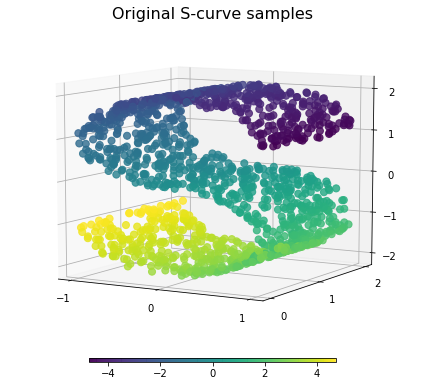

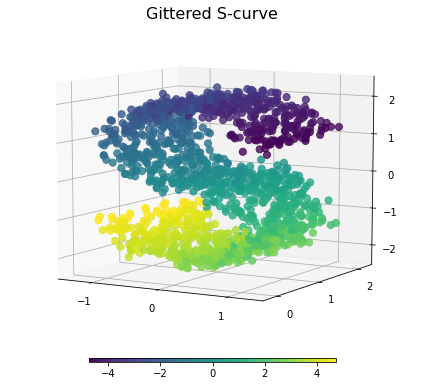

In [17]:
import sklearn.datasets as sk_datasets
from matplotlib import ticker
n_samples = 1500
S_points, S_color = sk_datasets.make_s_curve(n_samples)
print(S_points.shape, S_color.shape)
plot_3d(S_points, S_color, "Original S-curve samples")

S_points_gittered = S_points + np.random.randn(S_points.shape[0], S_points.shape[1])/10
plot_3d(S_points_gittered, S_color, "Gittered S-curve")

# 0) PCA

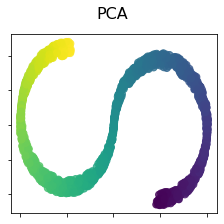

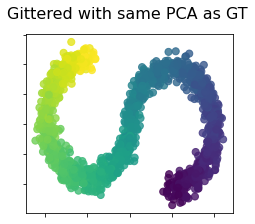

In [5]:
PCA = sk_decomposition.PCA(n_components=2)
S_PCA = PCA.fit_transform(S_points)

plot_2d(S_PCA, S_color, title="PCA")

Sg_PCA = PCA.transform(S_points_gittered)
plot_2d(Sg_PCA, S_color, title="Gittered with same PCA as GT")

# 1) Locally Linear Embeddings
Locally linear embedding (LLE) can be thought of as a series of local Principal Component Analyses which are globally compared to find the best non-linear embedding.

In [6]:
params = {
    "n_neighbors": n_neighbors,
    "n_components": n_components,
    "eigen_solver": "auto"
}

lle_standard = sk_manifold.LocallyLinearEmbedding(method="standard", **params)
S_standard = lle_standard.fit_transform(S_points)
Sg_standard = lle_standard.transform(S_points_gittered)


lle_ltsa = sk_manifold.LocallyLinearEmbedding(method="ltsa", **params)
S_ltsa = lle_ltsa.fit_transform(S_points)
Sg_ltsa = lle_ltsa.transform(S_points_gittered)


lle_hessian = sk_manifold.LocallyLinearEmbedding(method="hessian", **params)
S_hessian = lle_hessian.fit_transform(S_points)
Sg_hessian = lle_hessian.transform(S_points_gittered)


lle_mod = sk_manifold.LocallyLinearEmbedding(method="modified", modified_tol=0.8, **params)
S_mod = lle_mod.fit_transform(S_points)
Sg_mod = lle_mod.transform(S_points_gittered)

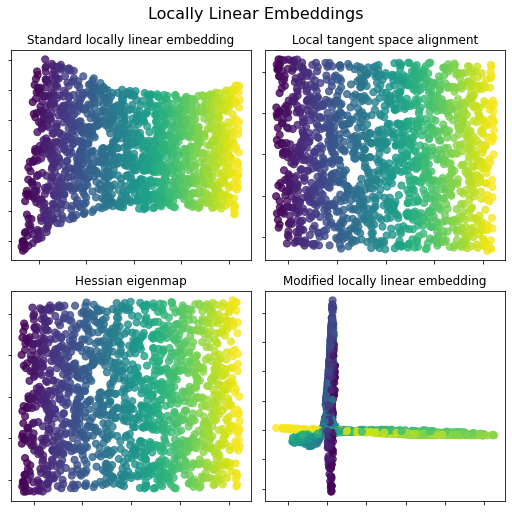

In [7]:
fig, axs = plt.subplots(
    nrows=2, ncols=2, figsize=(7, 7), facecolor="white", constrained_layout=True
)
fig.suptitle("Locally Linear Embeddings", size=16)

lle_methods = [
    ("Standard locally linear embedding", S_standard),
    ("Local tangent space alignment", S_ltsa),
    ("Hessian eigenmap", S_hessian),
    ("Modified locally linear embedding", S_mod),
]
for ax, method in zip(axs.flat, lle_methods):
    name, points = method
    add_2d_scatter(ax, points, S_color, name)

plt.show()


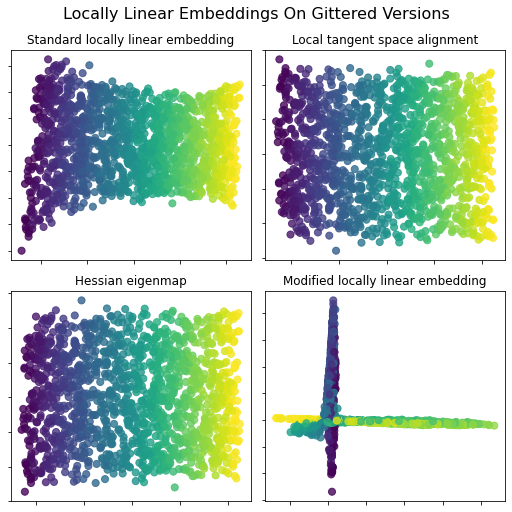

In [8]:
fig, axs = plt.subplots(
    nrows=2, ncols=2, figsize=(7, 7), facecolor="white", constrained_layout=True
)
fig.suptitle("Locally Linear Embeddings On Gittered Versions", size=16)

lle_methods = [
    ("Standard locally linear embedding", Sg_standard),
    ("Local tangent space alignment", Sg_ltsa),
    ("Hessian eigenmap", Sg_hessian),
    ("Modified locally linear embedding", Sg_mod),
]
for ax, method in zip(axs.flat, lle_methods):
    name, points = method
    add_2d_scatter(ax, points, S_color, name)

plt.show()


# (2) Isomap Embedding
Non-linear dimensionality reduction through Isometric Mapping. Isomap seeks a lower-dimensional embedding which maintains geodesic distances between all points

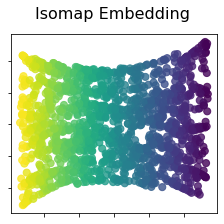

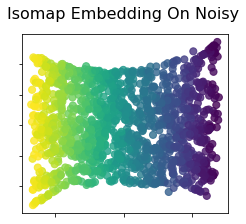

In [9]:
isomap = sk_manifold.Isomap(n_neighbors=n_neighbors, n_components=n_components, p=1)
S_isomap = isomap.fit_transform(S_points)

plot_2d(S_isomap, S_color, "Isomap Embedding")

S_isomap = isomap.transform(S_points_gittered)

plot_2d(S_isomap, S_color, "Isomap Embedding On Noisy")

# (3) Multidimensional scaling (MDS) No tiene transform!

Seeks a low-dimensional representation of the data in which the distances respect well the distances in the original high-dimensional space

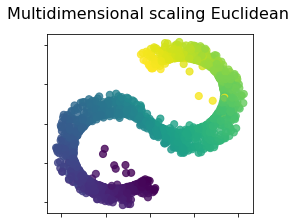

In [10]:
from scipy.spatial import distance_matrix

md_scaling_Euclidean = sk_manifold.MDS(
    n_components=n_components, max_iter=50, n_init=4, dissimilarity="euclidean"
)
S_scaling_Euclidean = md_scaling_Euclidean.fit_transform(S_points)

plot_2d(S_scaling_Euclidean, S_color, "Multidimensional scaling Euclidean")

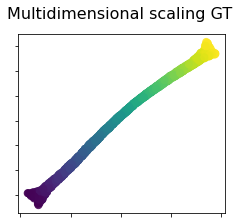

In [12]:
md_scaling_GTy = sk_manifold.MDS(
    n_components=n_components, max_iter=50, n_init=4, dissimilarity="precomputed"
)
S_scaling_GTy = md_scaling_GTy.fit_transform(np.abs(S_color[np.newaxis,:]-S_color[:,np.newaxis]))

plot_2d(S_scaling_GTy, S_color, "Multidimensional scaling GT")

# UMAP

In [19]:
a = np.round(S_color, 2)*100
a = a+np.abs(a.min())
a = a.astype(int)

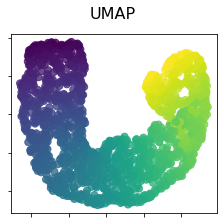

In [20]:
import umap
mapa = umap.UMAP(n_neighbors = 20, min_dist=0.9, n_components=2, metric="euclidean")
S_points_umapo = mapa.fit_transform(S_points, y=a)
plot_2d(S_points_umapo, S_color, "UMAP")

In [31]:
?umap.utils.check_is_fitted

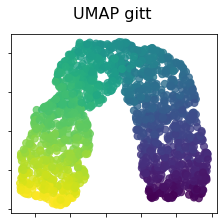

In [44]:
S_points_umapo = mapa.transform(S_points_gittered)
plot_2d(S_points_umapo, S_color, "UMAP gitt")

# Neighborhood Component Analysis

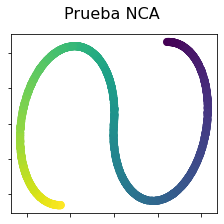

In [36]:
NCA = sk.neighbors.NeighborhoodComponentsAnalysis(n_components=2, init='auto', warm_start=False, max_iter=50, tol=1e-05, random_state=999)
S_points_NCA = NCA.fit_transform(S_points, y=a)
plot_2d(S_points_NCA/np.mean(np.abs(S_points_NCA)), S_color, "Prueba NCA")

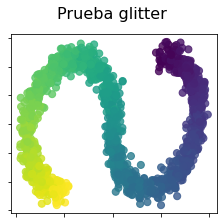

In [38]:
s = NCA.transform(S_points_gittered)
plot_2d(s, S_color, "Prueba glitter")

# KNN

0.9981419801595075


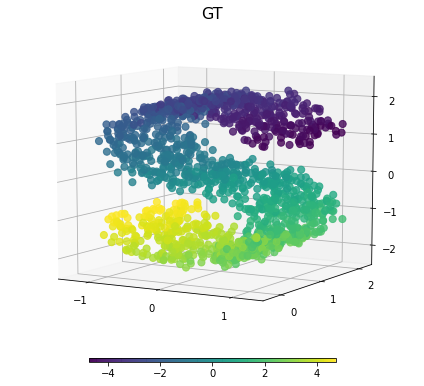

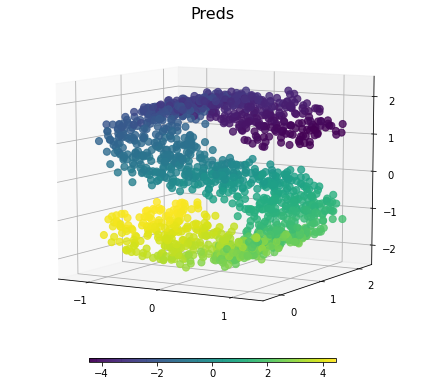

In [40]:
# ‘auto’, ‘ball_tree’, ‘kd_tree’, ‘brute’
# ‘uniform’, ‘distance’


KNN = sk.neighbors.KNeighborsRegressor(n_neighbors=50, weights='uniform', algorithm='auto',
                            leaf_size=30, p=2, metric='minkowski', metric_params=None, n_jobs=5)
KNN = KNN.fit(S_points, S_color)
print(KNN.score(S_points_gittered, S_color))
preds = KNN.predict(S_points_gittered)
plot_3d(S_points_gittered, S_color, title="GT")
plot_3d(S_points_gittered, preds, title="Preds")